# LSTM. 8 featerow - mag, x, y, depth, dist, distance, plate, days_diff

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
SEED = 1337
tf.random.set_seed(SEED)
np.random.seed(SEED)

2024-01-12 15:23:42.775733: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 15:23:42.775881: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 15:23:42.776150: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 15:23:42.806036: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 15:23:44.275457: W tensorflow/compiler/

In [2]:
ds_train = tf.data.Dataset.load("../data/ds_train_1/")
ds_val = tf.data.Dataset.load("../data/ds_val_1/")
ds_test = tf.data.Dataset.load("../data/ds_test_1/")

2024-01-12 15:23:46.155357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 15:23:46.267266: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 15:23:46.267372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 15:23:46.278048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 15:23:46.278296: I tensorflow/compile

In [3]:
ds_train.cardinality().numpy(), ds_val.cardinality().numpy(), ds_test.cardinality().numpy()

(3297488, 465661, 101326)

In [4]:
BATCH_SIZE = 1024
BLOCK_SIZE = 64

In [5]:
def fix_x_and_y(features, context, labels):
    return features, labels

In [6]:
ds_train = ds_train.map(fix_x_and_y)
ds_val = ds_val.map(fix_x_and_y)
ds_test = ds_test.map(fix_x_and_y)

In [7]:
for x, y in ds_train.batch(BATCH_SIZE).take(1):
    print(x.shape)
    print(x[:,:,:-3].shape, x[:,:,-3].shape, x[:,:,-2].shape, x[:,:,-1].shape)
    print(y.shape)

(1024, 32, 9)
(1024, 32, 6) (1024, 32) (1024, 32) (1024, 32)
(1024, 1)


In [8]:
# ys = []
# for x, y in ds_train.batch(BATCH_SIZE):
#     ys.append(y.numpy())
# ys = np.concatenate(ys)
# np.bincount(tf.cast(ys, tf.int32).numpy().flatten())

In [9]:
#neg, pos = np.bincount(tf.cast(ys, tf.int32).numpy().flatten())
neg, pos = 3096977, 200511
total = neg + pos
total, pos, neg

(3297488, 200511, 3096977)

In [10]:
ds_train = ds_train.batch(BATCH_SIZE).shuffle(2000, seed=SEED).prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
@tf.keras.saving.register_keras_serializable()
class MyModel(tf.keras.Model):
    def __init__(self, n_embed):
        super(MyModel, self).__init__()
        self.embed_plate = tf.keras.layers.Embedding(32, n_embed // 9, name="embed_plate")
        self.embed_dd = tf.keras.layers.Embedding(20, n_embed // 9, name="embed_dd")
        self.embed_magtype = tf.keras.layers.Embedding(20, n_embed // 9, name="embed_magtype")
        self.embed = tf.keras.layers.Dense(n_embed // 9 * 6, name="embed_continous")
        self.lstm1 = tf.keras.layers.LSTM(n_embed, return_sequences=True, name="lstm1")
        self.lstm2 = tf.keras.layers.LSTM(n_embed, name="lstm2")
        self.dense1 = tf.keras.layers.Dense(n_embed, activation='relu', name="pre_classifier")
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid', name="classifier")
        self.conc = tf.keras.layers.Concatenate(axis=-1, name="concatenate")

    def build_graph(self):
        x = [tf.keras.Input(shape=(BLOCK_SIZE, 6), batch_size=None, name="input_continous"),
        tf.keras.Input(shape=(BLOCK_SIZE), batch_size=None, name="input_plate"),
        tf.keras.Input(shape=(BLOCK_SIZE), batch_size=None, name="input_dd"),
        tf.keras.Input(shape=(BLOCK_SIZE), batch_size=None, name="input_magtype")]
        return tf.keras.Model(inputs=x, outputs=self.call(x))

    def call(self, x):
        #cont, plate, dd, magtype = x[:,:,:-3], x[:,:,-3], x[:,:,-2], x[:,:,-1]
        cont, plate, dd, magtype = x
        x1 = self.embed(cont)
        x2 = self.embed_plate(plate)
        x3 = self.embed_dd(dd)
        x4 = self.embed_magtype(magtype)
        x = self.conc([x1, x2, x3, x4])
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

In [12]:
model = MyModel(135)

In [13]:
model.build(input_shape=(None, BLOCK_SIZE, 9))
model.count_params()

ValueError: You cannot build your model by calling `build` if your layers do not support float type inputs. Instead, in order to instantiate and build your model, call your model on real tensor data (of the correct dtype).

The actual error from `call` is: Iterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information..

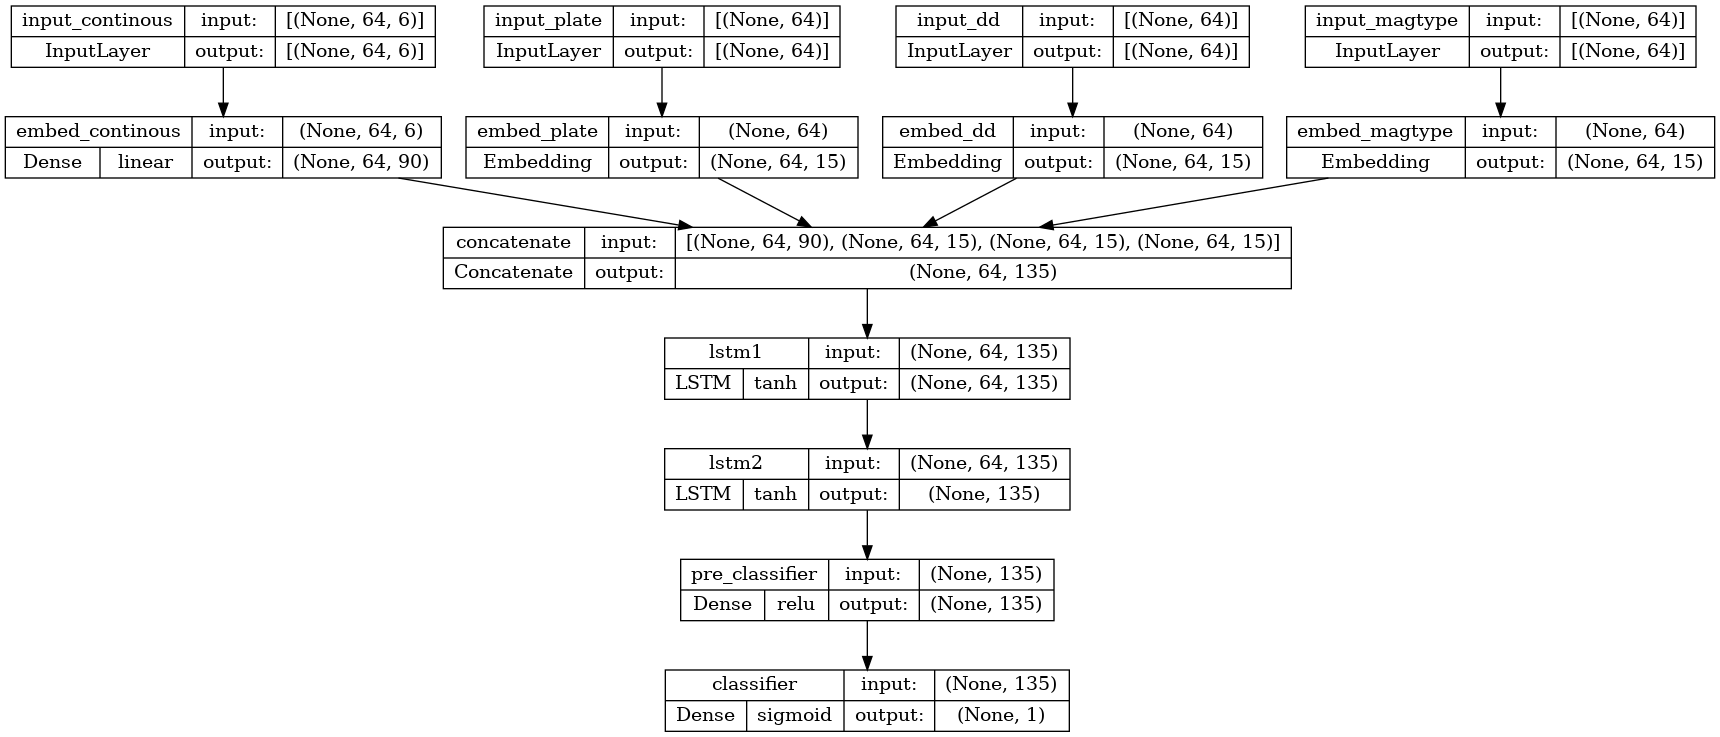

In [14]:
# plot the model architecture
tf.keras.utils.plot_model(model.build_graph(), show_shapes=True, expand_nested=True, show_layer_activations=True)

In [15]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            optimizer='adam',
            metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [16]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
history = model.fit(ds_train, epochs=20, validation_data=ds_val, class_weight = class_weight)

Epoch 1/20


2024-01-11 02:24:02.113083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 222 of 2000
2024-01-11 02:24:22.139112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 677 of 2000
2024-01-11 02:24:33.838290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 900 of 2000
2024-01-11 02:24:52.117090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1254 of 2000
2024-01-11 02:25:02.137173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1467 of 2000
2024-01-11 02:25:22.129871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take 

3221/3221 [==============================] - 492s 116ms/step - loss: 0.4676 - accuracy: 0.8302 - recall: 0.7515 - precision: 0.2280 - val_loss: 0.3740 - val_accuracy: 0.8788 - val_recall: 0.3964 - val_precision: 0.2280
Epoch 2/20


2024-01-11 02:32:08.895355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 157 of 2000
2024-01-11 02:32:28.858751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 514 of 2000
2024-01-11 02:32:38.881275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 703 of 2000
2024-01-11 02:32:58.851346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1076 of 2000
2024-01-11 02:33:08.862150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1262 of 2000
2024-01-11 02:33:18.883577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take 

3221/3221 [==============================] - 569s 143ms/step - loss: 0.4410 - accuracy: 0.8480 - recall: 0.7521 - precision: 0.2504 - val_loss: 0.3977 - val_accuracy: 0.8620 - val_recall: 0.4169 - val_precision: 0.2034
Epoch 3/20


2024-01-11 02:41:37.862521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 230 of 2000
2024-01-11 02:41:57.885373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 668 of 2000
2024-01-11 02:42:17.860326: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1146 of 2000
2024-01-11 02:42:27.874262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1388 of 2000
2024-01-11 02:42:47.865848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1860 of 2000
2024-01-11 02:42:53.673504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3221/3221 [==============================] - 547s 143ms/step - loss: 0.4259 - accuracy: 0.8519 - recall: 0.7594 - precision: 0.2571 - val_loss: 0.3819 - val_accuracy: 0.8727 - val_recall: 0.3870 - val_precision: 0.2128
Epoch 4/20


2024-01-11 02:50:44.848175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 242 of 2000
2024-01-11 02:51:04.831636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 714 of 2000
2024-01-11 02:51:24.845538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1196 of 2000
2024-01-11 02:51:44.840323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1674 of 2000
2024-01-11 02:51:58.450713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3221/3221 [==============================] - 544s 143ms/step - loss: 0.4096 - accuracy: 0.8466 - recall: 0.7805 - precision: 0.2531 - val_loss: 0.3552 - val_accuracy: 0.8731 - val_recall: 0.3812 - val_precision: 0.2118
Epoch 5/20


2024-01-11 02:59:48.977751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 239 of 2000
2024-01-11 02:59:59.000664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 474 of 2000
2024-01-11 03:00:19.004353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 955 of 2000
2024-01-11 03:00:29.006245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1191 of 2000
2024-01-11 03:00:48.996876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1674 of 2000
2024-01-11 03:01:02.530460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3221/3221 [==============================] - 544s 143ms/step - loss: 0.3953 - accuracy: 0.8386 - recall: 0.8082 - precision: 0.2471 - val_loss: 0.3444 - val_accuracy: 0.8794 - val_recall: 0.3721 - val_precision: 0.2215
Epoch 6/20


2024-01-11 03:08:52.884171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 240 of 2000
2024-01-11 03:09:02.884447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 482 of 2000
2024-01-11 03:09:22.855683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 970 of 2000
2024-01-11 03:09:32.879735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1213 of 2000
2024-01-11 03:09:52.867517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1700 of 2000
2024-01-11 03:10:05.281310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3221/3221 [==============================] - 543s 143ms/step - loss: 0.3752 - accuracy: 0.8455 - recall: 0.8194 - precision: 0.2578 - val_loss: 0.3518 - val_accuracy: 0.8450 - val_recall: 0.6578 - val_precision: 0.2346
Epoch 7/20


2024-01-11 03:17:55.845474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 238 of 2000
2024-01-11 03:18:15.818983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 714 of 2000
2024-01-11 03:18:35.828534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1197 of 2000
2024-01-11 03:18:45.828962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1440 of 2000
2024-01-11 03:19:05.814000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1924 of 2000
2024-01-11 03:19:08.941451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3221/3221 [==============================] - 544s 143ms/step - loss: 0.3596 - accuracy: 0.8435 - recall: 0.8373 - precision: 0.2578 - val_loss: 0.3309 - val_accuracy: 0.8649 - val_recall: 0.5652 - val_precision: 0.2458
Epoch 8/20


2024-01-11 03:27:00.270622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 244 of 2000
2024-01-11 03:27:20.260622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 725 of 2000
2024-01-11 03:27:30.284419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 967 of 2000
2024-01-11 03:27:50.261669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1449 of 2000
2024-01-11 03:28:10.265598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1924 of 2000
2024-01-11 03:28:13.465687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3221/3221 [==============================] - 544s 143ms/step - loss: 0.3469 - accuracy: 0.8528 - recall: 0.8426 - precision: 0.2713 - val_loss: 0.3560 - val_accuracy: 0.8649 - val_recall: 0.5501 - val_precision: 0.2424
Epoch 9/20


2024-01-11 03:36:04.034994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 239 of 2000
2024-01-11 03:36:24.031774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 712 of 2000
2024-01-11 03:36:34.053322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 952 of 2000
2024-01-11 03:36:54.061261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1430 of 2000
2024-01-11 03:37:14.032930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1913 of 2000
2024-01-11 03:37:17.671176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3221/3221 [==============================] - 544s 143ms/step - loss: 0.3322 - accuracy: 0.8569 - recall: 0.8526 - precision: 0.2787 - val_loss: 0.3913 - val_accuracy: 0.8397 - val_recall: 0.5459 - val_precision: 0.2047
Epoch 10/20


2024-01-11 03:45:08.352534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 239 of 2000
2024-01-11 03:45:18.374275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 477 of 2000
2024-01-11 03:45:38.357883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 955 of 2000
2024-01-11 03:45:48.365007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1195 of 2000
2024-01-11 03:45:58.367760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1436 of 2000
2024-01-11 03:46:18.350996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take 

3221/3221 [==============================] - 544s 143ms/step - loss: 0.3212 - accuracy: 0.8611 - recall: 0.8589 - precision: 0.2861 - val_loss: 0.4953 - val_accuracy: 0.8426 - val_recall: 0.5668 - val_precision: 0.2130
Epoch 11/20


2024-01-11 03:54:12.488304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 241 of 2000
2024-01-11 03:54:32.461592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 708 of 2000
2024-01-11 03:54:42.484849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 943 of 2000
2024-01-11 03:55:02.464290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1420 of 2000
2024-01-11 03:55:22.475102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1902 of 2000
2024-01-11 03:55:26.635275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3221/3221 [==============================] - 545s 143ms/step - loss: 0.3102 - accuracy: 0.8633 - recall: 0.8669 - precision: 0.2907 - val_loss: 0.4267 - val_accuracy: 0.8362 - val_recall: 0.5921 - val_precision: 0.2104
Epoch 12/20


2024-01-11 04:03:17.647750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 244 of 2000
2024-01-11 04:03:37.661366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 724 of 2000
2024-01-11 04:03:57.646095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1200 of 2000
2024-01-11 04:04:17.637939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1684 of 2000
2024-01-11 04:04:30.622715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3221/3221 [==============================] - 544s 143ms/step - loss: 0.3025 - accuracy: 0.8659 - recall: 0.8722 - precision: 0.2957 - val_loss: 0.4013 - val_accuracy: 0.8553 - val_recall: 0.5584 - val_precision: 0.2288
Epoch 13/20


2024-01-11 04:12:21.257298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 237 of 2000
2024-01-11 04:12:31.265152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 475 of 2000
2024-01-11 04:12:41.267015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 710 of 2000
2024-01-11 04:12:51.270651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 944 of 2000
2024-01-11 04:13:01.284037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1179 of 2000
2024-01-11 04:13:21.268465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a

3221/3221 [==============================] - 546s 143ms/step - loss: 0.2903 - accuracy: 0.8708 - recall: 0.8785 - precision: 0.3048 - val_loss: 0.4370 - val_accuracy: 0.8526 - val_recall: 0.5159 - val_precision: 0.2151
Epoch 14/20


2024-01-11 04:21:27.040100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 243 of 2000
2024-01-11 04:21:37.064596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 481 of 2000
2024-01-11 04:21:57.049260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 961 of 2000
2024-01-11 04:22:07.059201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1201 of 2000
2024-01-11 04:22:27.045938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1679 of 2000
2024-01-11 04:22:37.048380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take 

3221/3221 [==============================] - 544s 143ms/step - loss: 0.2818 - accuracy: 0.8726 - recall: 0.8846 - precision: 0.3088 - val_loss: 0.5096 - val_accuracy: 0.8447 - val_recall: 0.5685 - val_precision: 0.2161
Epoch 15/20


2024-01-11 04:30:30.796606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 238 of 2000
2024-01-11 04:30:50.791993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 711 of 2000
2024-01-11 04:31:10.758805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1187 of 2000
2024-01-11 04:31:20.801857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1424 of 2000
2024-01-11 04:31:40.783698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1896 of 2000
2024-01-11 04:31:45.175025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3221/3221 [==============================] - 545s 143ms/step - loss: 0.2724 - accuracy: 0.8769 - recall: 0.8898 - precision: 0.3172 - val_loss: 0.4553 - val_accuracy: 0.8419 - val_recall: 0.5051 - val_precision: 0.1981
Epoch 16/20


2024-01-11 04:39:35.817254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 240 of 2000
2024-01-11 04:39:45.835721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 478 of 2000
2024-01-11 04:40:05.844434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 960 of 2000
2024-01-11 04:40:15.848803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1200 of 2000
2024-01-11 04:40:35.837666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1682 of 2000
2024-01-11 04:40:48.887541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3221/3221 [==============================] - 544s 143ms/step - loss: 0.2622 - accuracy: 0.8791 - recall: 0.8968 - precision: 0.3224 - val_loss: 0.5027 - val_accuracy: 0.8387 - val_recall: 0.5665 - val_precision: 0.2080
Epoch 17/20


2024-01-11 04:48:39.520321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 242 of 2000
2024-01-11 04:48:59.498574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 723 of 2000
2024-01-11 04:49:19.506764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1204 of 2000
2024-01-11 04:49:39.508601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1688 of 2000
2024-01-11 04:49:52.395116: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3221/3221 [==============================] - 544s 143ms/step - loss: 0.2535 - accuracy: 0.8815 - recall: 0.9033 - precision: 0.3278 - val_loss: 0.4907 - val_accuracy: 0.8550 - val_recall: 0.5303 - val_precision: 0.2220
Epoch 18/20


2024-01-11 04:57:43.330997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 242 of 2000
2024-01-11 04:57:53.334047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 484 of 2000
2024-01-11 04:58:03.336954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 726 of 2000
2024-01-11 04:58:13.340937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 969 of 2000
2024-01-11 04:58:33.322847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1457 of 2000
2024-01-11 04:58:53.329802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a

3221/3221 [==============================] - 543s 143ms/step - loss: 0.2434 - accuracy: 0.8848 - recall: 0.9097 - precision: 0.3351 - val_loss: 0.5049 - val_accuracy: 0.8388 - val_recall: 0.5101 - val_precision: 0.1956
Epoch 19/20


2024-01-11 05:06:46.614807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 240 of 2000
2024-01-11 05:07:06.596297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 712 of 2000
2024-01-11 05:07:16.603295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 946 of 2000
2024-01-11 05:07:26.625550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1184 of 2000
2024-01-11 05:07:46.613500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1656 of 2000
2024-01-11 05:08:01.041945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3221/3221 [==============================] - 545s 143ms/step - loss: 0.2344 - accuracy: 0.8871 - recall: 0.9157 - precision: 0.3406 - val_loss: 0.5637 - val_accuracy: 0.8454 - val_recall: 0.5104 - val_precision: 0.2039
Epoch 20/20


2024-01-11 05:15:51.950397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 242 of 2000
2024-01-11 05:16:01.981521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 481 of 2000
2024-01-11 05:16:21.961329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 958 of 2000
2024-01-11 05:16:31.969327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1198 of 2000
2024-01-11 05:16:51.979459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1679 of 2000
2024-01-11 05:17:05.379439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


3221/3221 [==============================] - 547s 144ms/step - loss: 0.2275 - accuracy: 0.8903 - recall: 0.9185 - precision: 0.3478 - val_loss: 0.5798 - val_accuracy: 0.8533 - val_recall: 0.5372 - val_precision: 0.2211


In [17]:
model.evaluate(ds_test)

99/99 [==============================] - 6s 54ms/step - loss: 0.3219 - accuracy: 0.8678 - recall: 0.7548 - precision: 0.1184


[0.3218810260295868,
 0.8678325414657593,
 0.7548161149024963,
 0.11843913048505783]

In [18]:
model.save("../models/model_v5_cw.keras")

In [19]:
# save history
history = pd.DataFrame.from_dict(history.history)
history.to_csv("../models/history_model_v5_cw.csv", index=False)